<a href="https://colab.research.google.com/github/wonjae124/Capston/blob/main/TabNet_%EC%BD%94%EB%93%9C%EA%B5%AC%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch-tabnet

Documentation

https://dreamquark-ai.github.io/tabnet/generated_docs/README.html#tabnet-attentive-interpretable-tabular-learning

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from pytorch_tabnet.tab_model import TabNetClassifier

In [5]:
train = pd.read_csv("/content/drive/MyDrive/TabNet/census-income.data.gz",header = None)


In [6]:
target = 41 # 41번째 소득에 해당하는 칼럼이 있다.
if "Set" not in train.columns: #데이터셋에서 Set으로 나누어져 있지 않으면 직접 나눈다.
    train["Set"] = np.random.choice(["train","valid","test"],p=[.8, .1, .1], size = (train.shape[0],)) #size가 얼마일까?

train_indices = train[train.Set=="train"].index #0부터 시작하는 integer index 성질을 부여한다.
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set == "test"].index

unique()는 고유값의 종류(이름)을 알게 해주고
nunique()는 고유값의 수를 출력해준다.


In [7]:
nunique = train.nunique() #unique(?)한 값이 200개 이하이면 Categorical 변수로 치환
types = train.dtypes     #200개 이상이면 Numerical로 판단하여 Null value를 평균값으로 대체한다.

categorical_columns = []
categorical_dims = {}
for col in train.columns:
    if types[col]=='object' or nunique[col] < 200: #object이면 카테고리컬로 치환한다.
        print(f"col: {col}, unique:{train[col].unique()}")
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("wonjae") #오브젝트 결측치는 문자열로 채워
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace = True) #수치화 Null 값에 대해서는 해당 열의 numerical 변수들의 평균을 입력 시켜준다.
#   데이터 프레임에서 loc는 인덱스 기준, iloc은 adress 기준으로 나열한다.

unused_feat = ['Set']
features = [col for col in train.columns if col not in unused_feat+[target]] #Set과 소득 칼럼을 제외하고 사용할 피쳐로 만든다.
cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns] # 이 쪽 파트 잘 이해가 안 되니 다시 확인!!!!!!!!!!! 22.03.03
cat_dims = [categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns] # 학습 할 column 중에 카테고리 칼럼의 차원으로 리스트를 형성

X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

col: 0, unique:[73 58 18  9 10 48 42 28 47 34  8 32 51 46 26 13 39 16 35 12 27 56 55  2
  1 37  4 63 25 81 11 30  7 66 84 52  5 36 72 61 41 90 49  6  0 33 57 50
 24 17 53 40 54 22 29 85 38 76 21 31 74 19 15  3 43 68 71 45 62 23 69 75
 44 59 60 64 65 70 67 78 20 14 83 86 89 77 79 82 80 87 88]
col: 1, unique:[' Not in universe' ' Self-employed-not incorporated' ' Private'
 ' Local government' ' Federal government' ' Self-employed-incorporated'
 ' State government' ' Never worked' ' Without pay']
col: 2, unique:[ 0  4 40 34 43 37 24 39 12 35 45  3 19 29 32 48 33 23 44 36 31 30 41  5
 11  9 42  6 18 50  2  1 26 47 16 14 22 17  7  8 25 46 27 15 13 49 38 21
 28 20 51 10]
col: 3, unique:[ 0 34 10  3 40 26 37 31 12 36 41 22  2 35 25 23 42  8 19 29 27 16 33 13
 18  9 17 39 32 11 30 38 20  7 21 44 24 43 28  4  1  6 45 14  5 15 46]
col: 4, unique:[' High school graduate' ' Some college but no degree' ' 10th grade'
 ' Children' ' Bachelors degree(BA AB BS)'
 ' Masters degree(MA MS MEng MEd MSW MBA

그리고 논문리뷰에서 설명했듯이 TabNet은 입력으로 Categorical변수를 Embedding 하기 때문에, Categorical 변수라는 것을 지정해주어야 합니다. 따라서, cat_idxs와 cat_dims를 저장해둡니다.

In [8]:
clf = TabNetClassifier(cat_idxs = cat_idxs,
                       cat_dims = cat_dims,
                       cat_emb_dim = 10,
                       optimizer_fn = torch.optim.Adam,
                       optimizer_params = dict(lr=1e-2),
                       scheduler_params = {"step_size":50,
                                           "gamma":0.9},
                       scheduler_fn = torch.optim.lr_scheduler.StepLR,
                       mask_type = 'sparsemax' 
                       )

Device used : cuda


In [9]:
max_epochs = 15

clf.fit(
    X_train = X_train,
    y_train = y_train,
    eval_set = [(X_train, y_train), (X_valid, y_valid)],
    eval_metric=['auc'],
    max_epochs = max_epochs,
    patience = 20,
    batch_size = 1024,
    virtual_batch_size = 128,
    num_workers = 0,
    weights = 1,
    drop_last = False,
)

epoch 0  | loss: 0.51595 | val_0_auc: 0.89212 | val_1_auc: 0.88635 |  0:00:11s
epoch 1  | loss: 0.39282 | val_0_auc: 0.91093 | val_1_auc: 0.90693 |  0:00:22s
epoch 2  | loss: 0.36907 | val_0_auc: 0.921   | val_1_auc: 0.91446 |  0:00:33s
epoch 3  | loss: 0.34468 | val_0_auc: 0.9329  | val_1_auc: 0.9257  |  0:00:44s
epoch 4  | loss: 0.32155 | val_0_auc: 0.942   | val_1_auc: 0.93286 |  0:00:56s
epoch 5  | loss: 0.30019 | val_0_auc: 0.94835 | val_1_auc: 0.93874 |  0:01:07s
epoch 6  | loss: 0.28588 | val_0_auc: 0.95301 | val_1_auc: 0.94054 |  0:01:18s
epoch 7  | loss: 0.27989 | val_0_auc: 0.95393 | val_1_auc: 0.94167 |  0:01:29s
epoch 8  | loss: 0.27203 | val_0_auc: 0.9574  | val_1_auc: 0.94487 |  0:01:40s
epoch 9  | loss: 0.2633  | val_0_auc: 0.95881 | val_1_auc: 0.94242 |  0:01:51s
epoch 10 | loss: 0.26285 | val_0_auc: 0.96049 | val_1_auc: 0.94345 |  0:02:03s
epoch 11 | loss: 0.25768 | val_0_auc: 0.96192 | val_1_auc: 0.9423  |  0:02:15s
epoch 12 | loss: 0.25195 | val_0_auc: 0.96215 | val_

In [32]:
preds = clf.predict_proba(X_test)
positive_test_auc = roc_auc_score(y_score = preds[:,1], y_true=y_test) # preds의 두 번째 열은 Positive, 첫 번째 열은 Negative이다.
negative_test_auc = roc_auc_score(y_score = preds[:,0], y_true=y_test)

In [33]:
positive_test_auc

0.952438662016363

In [34]:
negative_test_auc

0.04756133798363704

# 샘플 전체에 대한 변수 중요도 시각화

In [40]:
explain_matrix , masks = clf.explain(X_test)


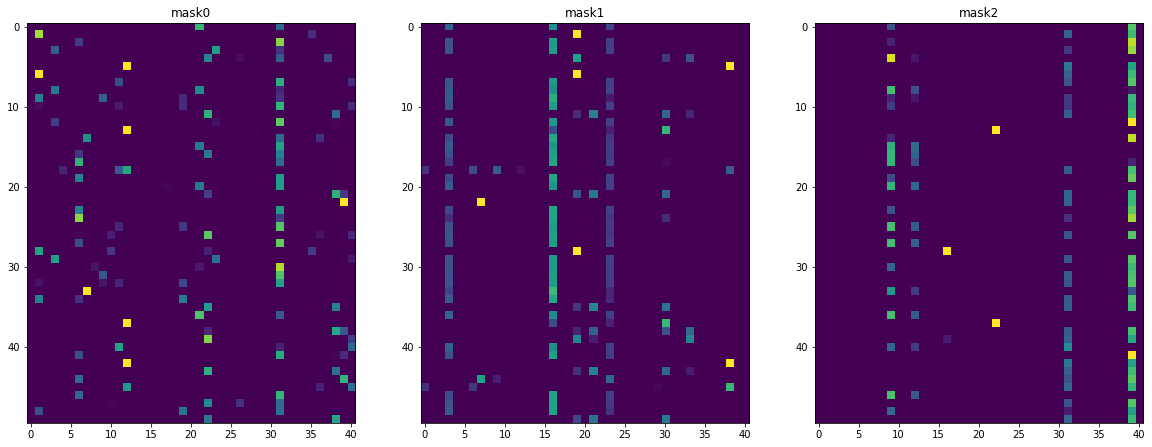

In [39]:
fig, axs = plt.subplots(1, 3, figsize = (20,20))
for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask{i}")

# 0번 샘플은 31번 변수. 1번 샘플은 16번 변수, 2번 샘플은 39번 변수가 영향을 많이 미친 것으로 판별 됬다.

In [15]:
preds

array([[0.08979011, 0.9102099 ],
       [0.9949673 , 0.00503277],
       [0.8602526 , 0.13974737],
       ...,
       [0.91077524, 0.08922476],
       [0.06766896, 0.9323311 ],
       [0.928142  , 0.07185797]], dtype=float32)

In [26]:
preds[:,0]

array([0.08979011, 0.9949673 , 0.8602526 , ..., 0.91077524, 0.06766896,
       0.928142  ], dtype=float32)

In [27]:
preds[:,1]

array([0.9102099 , 0.00503277, 0.13974737, ..., 0.08922476, 0.9323311 ,
       0.07185797], dtype=float32)

In [31]:
print(test_auc)

0.952438662016363


In [43]:
categorical_columns

[0,
 1,
 2,
 3,
 4,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 19,
 20,
 21,
 22,
 23,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 'Set']

In [44]:
print(categorical_columns)

[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 'Set']


In [45]:
cat_idxs

[0,
 1,
 2,
 3,
 4,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 19,
 20,
 21,
 22,
 23,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40]

In [46]:
unused_feat+[target]

['Set', 41]

In [47]:
print(train.columns)

Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
          10,    11,    12,    13,    14,    15,    16,    17,    18,    19,
          20,    21,    22,    23,    24,    25,    26,    27,    28,    29,
          30,    31,    32,    33,    34,    35,    36,    37,    38,    39,
          40,    41, 'Set'],
      dtype='object')


In [48]:
persons = [
    ['egoing','Seoul','Web'],
    ['basta','Seoul','IOT'],
    ['blackdew','Tongyeong','ML'],
]

print(persons[0][0],'\n')

print(len(persons),'\n')

for i, (person) in enumerate(persons):
    print(i, person[0]+' '+person[1]+' '+person[2])



egoing 

3 

0 egoing Seoul Web
1 basta Seoul IOT
2 blackdew Tongyeong ML


In [49]:
train.columns

Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
          10,    11,    12,    13,    14,    15,    16,    17,    18,    19,
          20,    21,    22,    23,    24,    25,    26,    27,    28,    29,
          30,    31,    32,    33,    34,    35,    36,    37,    38,    39,
          40,    41, 'Set'],
      dtype='object')

In [50]:
features

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40]

In [51]:
print(train.loc[train_indices, col])

0         1
1         1
2         1
3         1
4         1
         ..
199517    1
199518    1
199519    1
199520    1
199521    1
Name: Set, Length: 159547, dtype: int64


loc 사용 예시

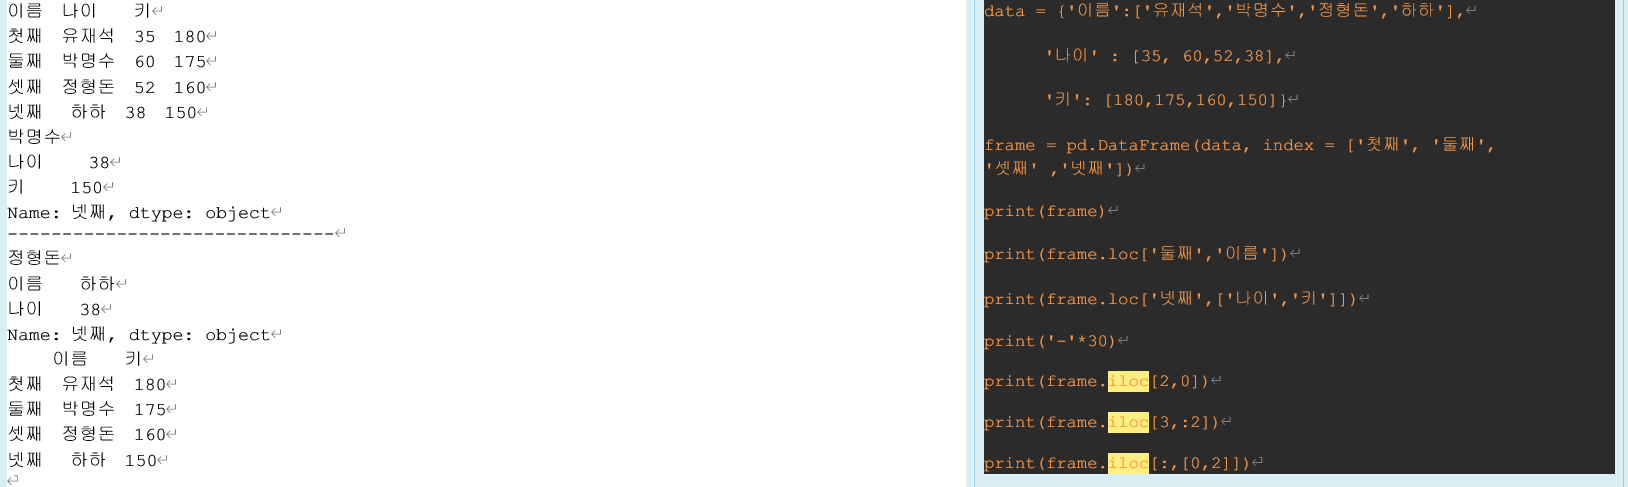

리스트 확인

In [52]:
print(nunique)

0         91
1          9
2         52
3         47
4         17
5       1240
6          3
7          7
8         24
9         15
10         5
11        10
12         2
13         3
14         6
15         8
16       132
17       113
18      1478
19         6
20         6
21        51
22        38
23         8
24     99800
25        10
26         9
27        10
28         3
29         4
30         7
31         5
32        43
33        43
34        43
35         5
36         3
37         3
38         3
39        53
40         2
41         2
Set        3
dtype: int64


In [53]:
print(train.dtypes)

0        int64
1        int64
2        int64
3        int64
4        int64
5        int64
6        int64
7        int64
8        int64
9        int64
10       int64
11       int64
12       int64
13       int64
14       int64
15       int64
16       int64
17       int64
18       int64
19       int64
20       int64
21       int64
22       int64
23       int64
24     float64
25       int64
26       int64
27       int64
28       int64
29       int64
30       int64
31       int64
32       int64
33       int64
34       int64
35       int64
36       int64
37       int64
38       int64
39       int64
40       int64
41       int64
Set      int64
dtype: object


출처 : https://wsshin.tistory.com/5